In [1]:
!pip install qiskit==0.42.1
!pip install qiskit-aer==0.12.0
!pip install qiskit-ibmq-provider==0.20.2
!pip install qiskit-terra==0.23.3

Elapsed time: 16.05


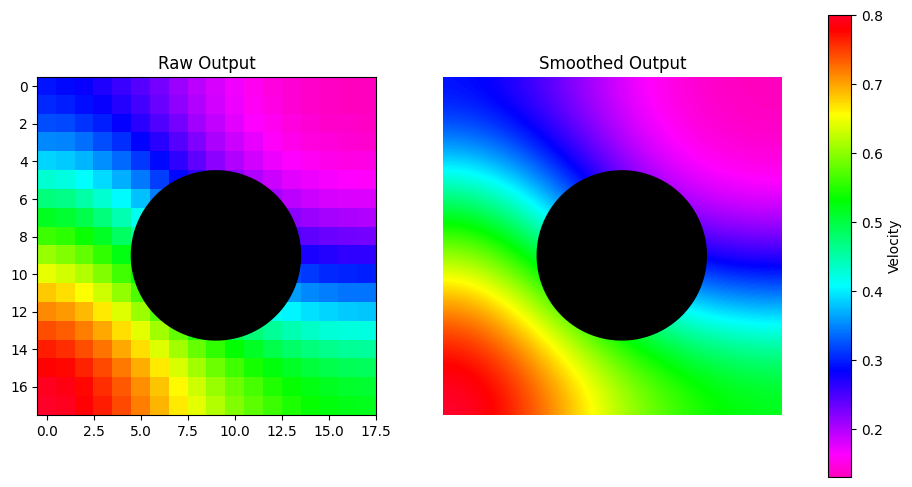

In [15]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from qiskit import QuantumCircuit, Aer, transpile

# Number of Qubits per side
N = 18

# Initialize Qubit Grid
num_qubits = N * N
shots = 4096

# Initialize Fluid "Source" column and rows
source_col = 2
source_rows = [6,7,8,9]

def circular_mask(N):
    ''' Generates a circular mask to simulate fluid flow around.'''
    center = N // 2
    y, x = np.ogrid[:N, :N]
    return (x - center)**2 + (y - center)**2 <= (N // 4)**2

time1 = time()
obstacle_mask = circular_mask(N)
fluid_mask = ~obstacle_mask

qc = QuantumCircuit(num_qubits, num_qubits)

# Apply Hadamard Gates to Source Rows
for row in source_rows:
    idx = row * N + source_col
    if fluid_mask[row, source_col]:
        qc.h(idx)

def get_neighbors(i, j, N):
    ''' Get the Neighboring pixels of a pixel. Includes diagonal neighbors, along with up, down, left, and right. '''
    for dx, dy in [(-1, -1), (-1, 0), (-1, 1),
                   ( 0, -1),          ( 0, 1),
                   ( 1, -1), ( 1, 0), ( 1, 1)]:
        ni, nj = i + dx, j + dy
        if 0 <= ni < N and 0 <= nj < N:
            yield ni, nj

def get_neighbors_standard(i, j, N):
    ''' Get the Neighboring pixels of a pixel. Includes up, down, left, and right. '''
    for dx, dy in [          (-1, 0),
                   ( 0, -1),          ( 0, 1),
                             ( 1, 0), ]:
        ni, nj = i + dx, j + dy
        if 0 <= ni < N and 0 <= nj < N:
            yield ni, nj

# Entangle Neighboring Qubits using get_neighbors(i, j, N) or def get_neighbors_standard(i, j, N)
for i in range(N):
    for j in range(N):
        if not fluid_mask[i, j]:
            continue
        idx = i * N + j
        for ni, nj in get_neighbors(i, j, N):
            if fluid_mask[ni, nj]:
                nidx = ni * N + nj
                qc.cx(idx, nidx)

# Apply rotations to Qubits contained in the fluid mask
for i in range(num_qubits):
    if fluid_mask[i // N, i % N]:
        qc.ry(np.pi / 6, i)

# Measure Circuit
qc.measure(range(num_qubits), range(num_qubits))

# Simulate on qasm_simulator
backend = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, backend)
result = backend.run(t_qc, shots=shots).result()
counts = result.get_counts()

# Construct a numpy array with frequencies from the Quantum Circuit
grid_vals = np.zeros((N, N))
for outcome, freq in counts.items():
    for q in range(num_qubits):
        i, j = q // N, q % N
        if fluid_mask[i, j] and outcome[::-1][q] == '1':
            grid_vals[i, j] += freq

# Normalize the values of the numpy array
grid_vals = grid_vals / np.max(grid_vals[fluid_mask])

# Apply a Gaussian Filter to smooth results
smoothed = gaussian_filter(grid_vals, sigma=5)

# Visualize Results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im = axs[0].imshow(smoothed, cmap='gist_rainbow_r', interpolation='nearest')

theta = np.linspace(0, 2 * np.pi, 100)
r = (N // 4) + 0.5
cx = cy = N // 2
x = cx + r * np.cos(theta)
y = cy + r * np.sin(theta)
axs[0].fill(x, y, color='black')
axs[0].set_title('Raw Output')

im2 = axs[1].imshow(smoothed, cmap='gist_rainbow_r', interpolation='bicubic')
axs[1].set_title('Smoothed Output')
axs[1].fill(x, y, color='black')

time2 = time()
print(f"Elapsed time: {round(time2-time1,2)}")
plt.colorbar(im, ax=axs, label='Velocity')
plt.axis('off')
plt.show()